In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn import preprocessing
from wordfreq import word_frequency

In [2]:
df = pd.read_excel("Data.xlsx")
df.index = np.flip(np.arange(df.shape[0]))
df.sort_values(by='Date', inplace=True)

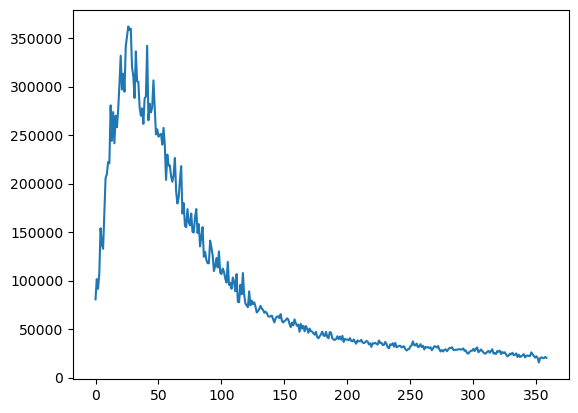

In [3]:
# 处理异常值
hard_counts = df['Number in hard mode'].values
all_counts = df['Number of  reported results'].values

err_id = np.where(all_counts < 5000)[0]
normal_id = np.delete(np.arange(len(all_counts)), err_id)
CS_all = CubicSpline(normal_id, all_counts[normal_id])
all_counts[err_id] = CS_all(err_id)


plt.plot(df['Number of  reported results'])

In [4]:
# 百分比归一化
df.iloc[:,5:12] = df.iloc[:,5:12].apply(lambda x: x / df.iloc[:,5:12].sum(axis=1) * 100)

In [5]:
word_freq = df.Word.apply(lambda x:word_frequency(x, 'en'))

In [6]:
letter_dup = df['Word'].apply(lambda x: 5 - len(set(x)))
letter_dup[letter_dup>=1] = 1

In [7]:
with open('allowed_words.txt') as fp:
    word_ls = fp.read().split('\n')
    word_ls.remove('')

In [8]:
letter_ls = []
for i in range(26):
    letter_ls.append(chr(ord('a') + i))

letter_freq = pd.Series(np.zeros(26),index=letter_ls)

for word in word_ls:
    freq = word_frequency(word, 'en')
    for i in range(5):
        if (ord(word[i]) >= ord('a')) and (ord(word[i]) <= ord('z')):
            letter_freq[word[i]] += 1 * freq

letter_freq = letter_freq / letter_freq.sum()

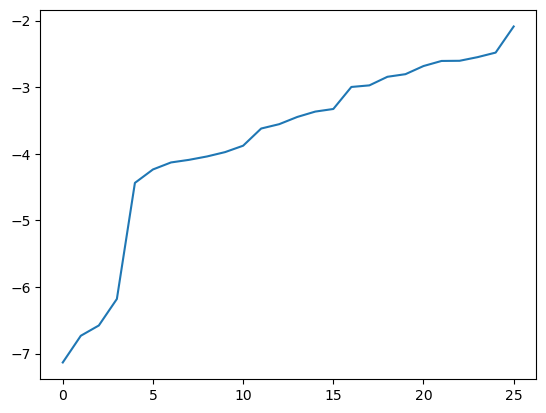

In [9]:
letter_score = np.log(letter_freq)
plt.plot(np.log(letter_freq.sort_values().values))

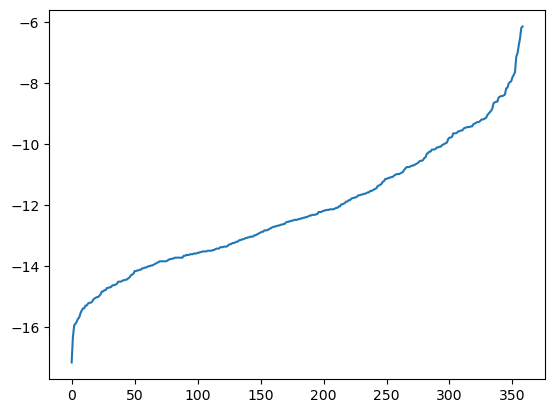

In [10]:
word_score = np.log(word_freq)
plt.plot(np.log(word_freq.sort_values().values))

In [11]:
def cal_letter_freq_score(word):
    score = 0
    for j in range(5):
        score += letter_score[word[j]]
    return score

letter_freq_score = np.zeros(df.shape[0])
for i in df.index:
    letter_freq_score[i] = cal_letter_freq_score(df.Word[i])

In [13]:
def cnt_word_sim(word):
    cnt = 0
    for wword in word_ls:
        ccnt = 0
        for j in range(5):
            if word[j]==wword[j]:
                ccnt += 1
        if(ccnt==4):
            cnt += 1
    return cnt

word_sim = np.zeros(df.shape[0])
for i in df.index:
    word_sim[i] = cnt_word_sim(df.Word[i])

In [14]:
df['letter_freq_score'] = letter_freq_score
df['letter_dup'] = letter_dup
df['word_freq_score'] = word_score
df['word_sim'] = word_sim

In [15]:
df.to_csv("data_preprocessed(新特征未归一化).csv", index=False)

In [16]:
new_df = df.copy()

min_max_scaler = preprocessing.MinMaxScaler()
new_df.iloc[:,12:] = min_max_scaler.fit_transform(new_df.iloc[:,12:])

C:\Users\19828\AppData\Local\Temp\ipykernel_3676\3940580577.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_df.iloc[:,12:] = min_max_scaler.fit_transform(new_df.iloc[:,12:])


In [17]:
new_df.to_csv("data_preprocessed(新特征归一化).csv", index=False)

In [18]:
new_df

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),letter_freq_score,letter_dup,word_freq_score,word_sim
0,2022-01-07,202,slump,80630,1362,1.000000,3.000000,23.000000,39.000000,24.000000,9.000000,1.000000,0.381061,0.0,0.378564,0.260870
1,2022-01-08,203,crank,101503,1763,1.000000,5.000000,23.000000,31.000000,24.000000,14.000000,2.000000,0.508926,0.0,0.430813,0.521739
2,2022-01-09,204,gorge,91477,1913,1.000000,3.000000,13.000000,27.000000,30.000000,22.000000,4.000000,0.682474,1.0,0.386898,0.217391
3,2022-01-10,205,query,107134,2242,1.000000,4.000000,16.000000,30.000000,30.000000,17.000000,2.000000,0.137907,0.0,0.437274,0.043478
4,2022-01-11,206,drink,153880,3017,0.990099,8.910891,34.653465,33.663366,15.841584,4.950495,0.990099,0.498868,0.0,0.700724,0.173913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2022-12-27,556,condo,20879,2012,0.000000,2.000000,17.000000,35.000000,29.000000,14.000000,3.000000,0.595093,1.0,0.435171,0.304348
355,2022-12-28,557,impel,20160,1937,0.000000,3.030303,21.212121,40.404040,25.252525,9.090909,1.010101,0.514752,0.0,0.169367,0.043478
356,2022-12-29,558,havoc,20001,1919,0.000000,2.000000,16.000000,38.000000,30.000000,12.000000,2.000000,0.486312,0.0,0.407821,0.000000
357,2022-12-30,559,molar,21204,1973,0.000000,4.040404,21.212121,38.383838,26.262626,9.090909,1.010101,0.650780,0.0,0.301174,0.391304


In [19]:
cal_letter_freq_score('eerie')

-11.624810029102072

In [20]:
cnt_word_sim('eerie')

2

In [21]:
np.log(word_frequency('eerie', 'en'))

-13.054704728930513